# Importing the Libraries

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import datetime as dt
import warnings
import sys
from keras.layers import LSTM, Dense
from keras.models import Sequential

# Suppress warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set plotting parameters
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)


# Loading the Dataset

In [85]:
df = pd.read_csv('Microsoft_Stock.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


# Data Preprocessing

In [86]:
# Checking for missing values
df.isnull().sum()

# Converting the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Setting the 'Date' column as the index
df.set_index('Date', inplace=True)

# Sorting the dataset by date
df.sort_index(ascending=True, inplace=True)

# Display the basic statistics of the dataset
df.describe()


,Open,High,Low,Close,Volume
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03
mean,107.385976,108.437472,106.294533,107.422091,3.019863e+07
std,56.691333,57.382276,55.977155,56.702299,1.425266e+07
min,40.340000,40.740000,39.720000,40.290000,1.016120e+05
25%,57.860000,58.060000,57.420000,57.855000,2.136213e+07
50%,93.990000,95.100000,92.920000,93.860000,2.662962e+07
75%,139.440000,140.325000,137.825000,138.965000,3.431962e+07
max,245.030000,246.130000,242.920000,244.990000,1.352271e+08


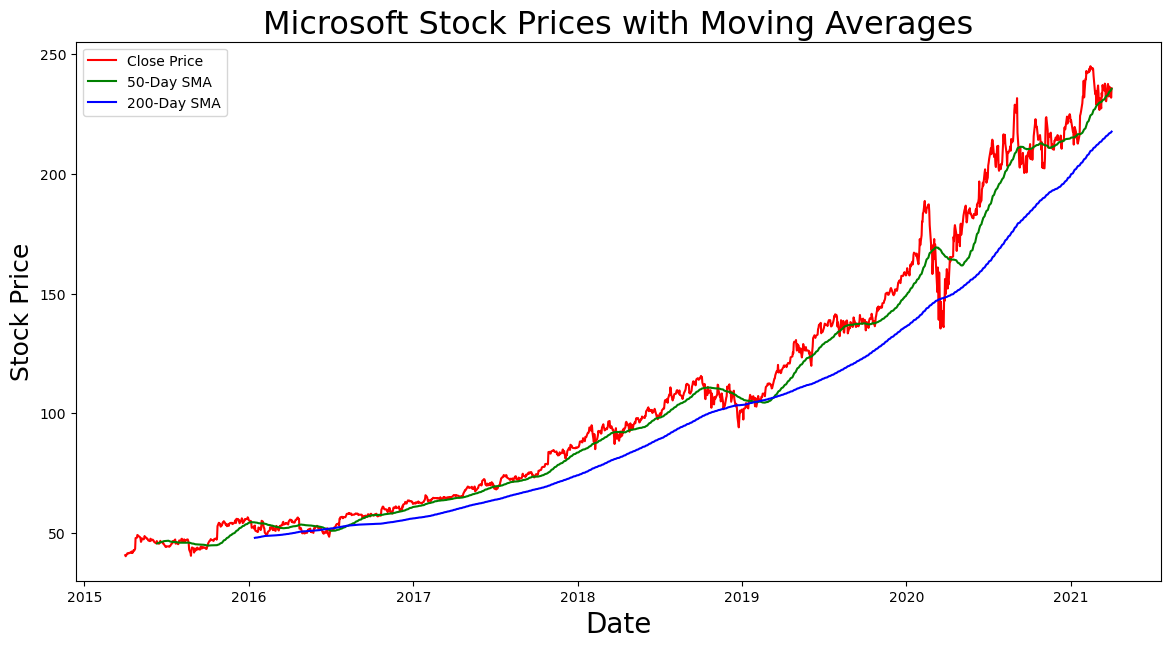

In [87]:
# Calculate moving averages
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()

# Plot the Close Price with Moving Averages
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Close Price', color='r')
plt.plot(df['SMA_50'], label='50-Day SMA', color='g')
plt.plot(df['SMA_200'], label='200-Day SMA', color='b')
plt.xlabel('Date', size=20)
plt.ylabel('Stock Price', size=18)
plt.title('Microsoft Stock Prices with Moving Averages', size=23)
plt.legend()
plt.show()


Text(0.5, 1.0, 'Microsoft Stock Prices Over the Years')

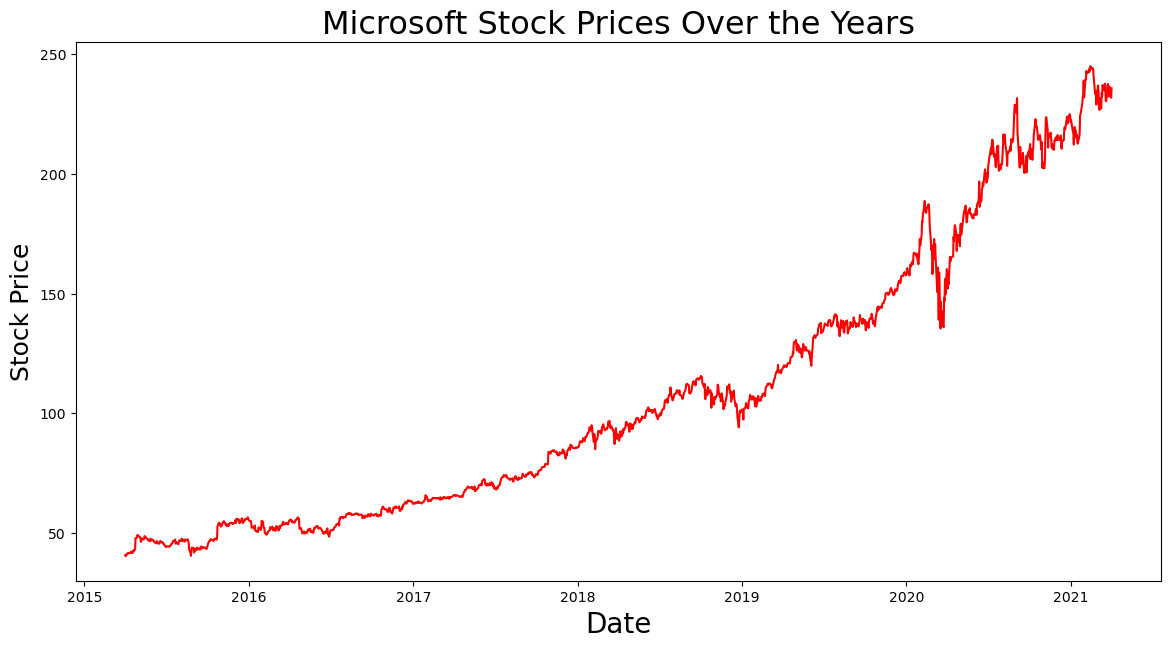

In [106]:
df = pd.read_csv('Microsoft_Stock.csv')
df['Date'] = pd.to_datetime(df.Date,format='%m/%d/%Y %H:%M:%S')
df.index = df['Date']
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Close Price history',color='r')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=18)
plt.title('Microsoft Stock Prices Over the Years',size=23)

### Preparing The Data

In [107]:
# Get the number of rows in the dataset
shape = df.shape[0]

# Extracting the 'Close' column for analysis
df_new = df[['Close']]
df_new.head()


,Close
Date,
2015-04-01 16:00:00,40.72
2015-04-02 16:00:00,40.29
2015-04-06 16:00:00,41.55
2015-04-07 16:00:00,41.53
2015-04-08 16:00:00,41.42


### Splitting the Data into Training and Validation Sets

In [108]:
# Split the data into training and validation sets (75% - 25% split)
train__data_set = df_new.iloc[:ceil(shape * 0.75)]
valid__data_set = df_new.iloc[ceil(shape * 0.75):]

print("***** Microsoft Stock Price Prediction Using Moving Averages *********")
print('Shape of Training Data Set of Microsoft Stock Prices:', train__data_set.shape)
print('Shape of Validation Data Set of Microsoft Stock Prices:', valid__data_set.shape)


***** Microsoft Stock Price Prediction Using Moving Averages *********
Shape of Training Data Set of Microsoft Stock Prices: (1134, 1)
Shape of Validation Data Set of Microsoft Stock Prices: (377, 1)


### Predicting Stock Prices Using Moving Averages

In [109]:
# Initialize predictions list
preds = []

# Generate predictions using the moving average
for i in range(0, valid__data_set.shape[0]):
    a = train__data_set['Close'][len(train__data_set) - valid__data_set.shape[0] + i:].sum() + sum(preds)
    b = a / valid__data_set.shape[0]
    preds.append(b)


### Calculating the RMSE (Root Mean Square Error)

In [110]:
# Calculate the RMSE value
RMS = np.sqrt(np.mean(np.power((np.array(valid__data_set['Close']) - preds), 2)))
print('(Root Mean Square Error) RMSE value on validation set:', RMS)

# Add predictions to the validation data
valid__data_set['Predictions'] = preds


(Root Mean Square Error) RMSE value on validation set: 76.62376749929759


# Random Forest Model

## Prepairing Data

In [111]:
# Get the number of rows in the dataset
Shape = df.shape[0]

# Extracting the 'Close' column for analysis
df_new = df[['Close']]
df_new.head()

# Split the data into training and validation sets (75% - 25% split)
train_data_set = df_new.iloc[:ceil(Shape * 0.75)]
valid_data_set = df_new.iloc[ceil(Shape * 0.75):]

print("**********STOCK PRICE PREDICTION BY RANDOM FOREST******")
print('Shape of Training dataset Set:', train_data_set.shape)
print('Shape of Validation dataset Set:', valid_data_set.shape)


**********STOCK PRICE PREDICTION BY RANDOM FOREST******
Shape of Training dataset Set: (1134, 1)
Shape of Validation dataset Set: (377, 1)


## Training and Validation Data

In [112]:
# Reset the index for train and validation data
train = train_data_set.reset_index()
valid = valid_data_set.reset_index()

# Convert dates to ordinal format for regression analysis
x_train = train['Date'].map(dt.datetime.toordinal)
y_train = train[['Close']]
x_valid = valid['Date'].map(dt.datetime.toordinal)
y_valid = valid[['Close']]


## Implementing Random Forest Regression

In [113]:
# Implement Random Forest Regressor
Model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
Model.fit(np.array(x_train).reshape(-1, 1), y_train.values.ravel())

# Predict the stock prices on the validation data
preds = Model.predict(np.array(x_valid).reshape(-1, 1))


## Calculating RMSE and Plotting Results


(Root Mean Square Error) RMSE value on validation set: 62.2398436758147


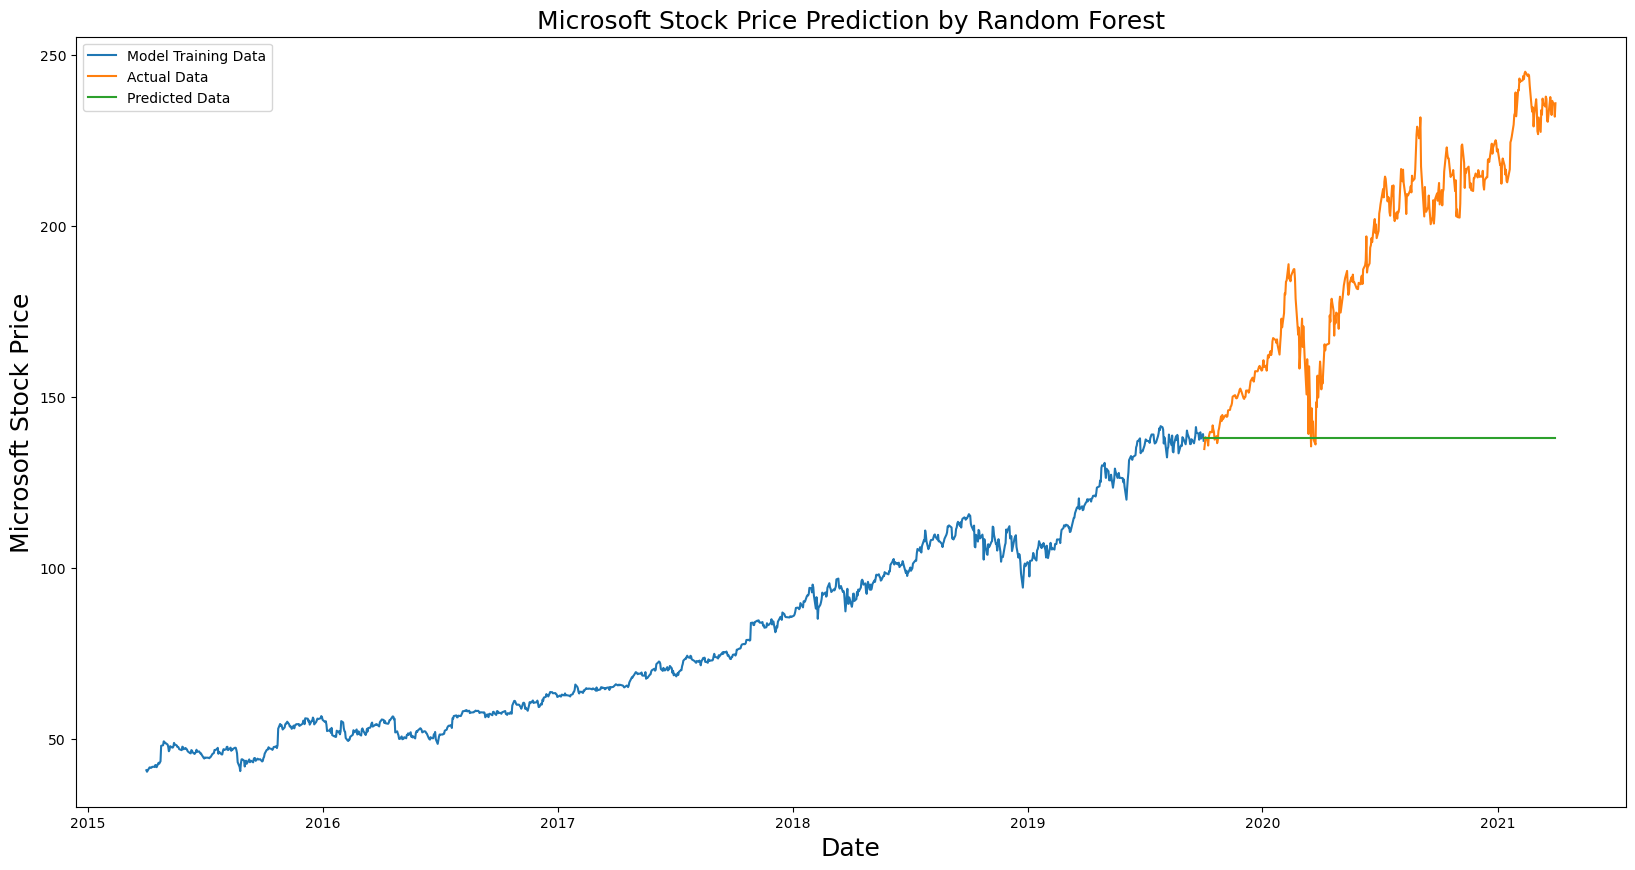

In [114]:
# Calculate the RMSE value
RMS = np.sqrt(np.mean(np.power((np.array(valid_data_set['Close']) - preds), 2)))
print('(Root Mean Square Error) RMSE value on validation set:', RMS)

# Add the predictions to the validation data
valid_data_set['Predictions'] = preds

# Plot the training data, actual validation data, and predicted data
plt.plot(train_data_set['Close'])
plt.plot(valid_data_set[['Close', 'Predictions']])
plt.xlabel('Date', size=18)
plt.ylabel('Microsoft Stock Price', size=18)
plt.title('Microsoft Stock Price Prediction by Random Forest', size=18)
plt.legend(['Model Training Data', 'Actual Data', 'Predicted Data'])
plt.show()


# LSTM Model



## Prepairing Data

In [115]:
# Get the number of rows in the dataset
shape = df.shape[0]

# Extracting the 'Close' column for analysis
df_new = df[['Close']]
df_new.head()

# Convert the dataframe to a numpy array for processing
dataset = df_new.values

# Split the data into training and validation sets (75% - 25% split)
train = df_new[:ceil(shape * 0.75)]
valid = df_new[ceil(shape * 0.75):]

print("******** Microsoft STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM) *******")
print('Shape of Training Data Set:', train.shape)
print('Shape of Validation Data Set:', valid.shape)

******** Microsoft STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM) *******
Shape of Training Data Set: (1134, 1)
Shape of Validation Data Set: (377, 1)


## Scaling and Creating Training Data

In [116]:
# Normalize the dataset using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data structure with 40 time steps and 1 output
X_train, Y_train = [], []
for i in range(40, len(train)):
    X_train.append(scaled_data[i-40:i, 0])
    Y_train.append(scaled_data[i, 0])

# Convert the training data to numpy arrays
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape the training data to be compatible with LSTM layers
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


## Building, Training, and Preparing Test Data

In [117]:
# Initialize the LSTM model
Model = Sequential()

# Adding the first LSTM layer and some Dropout regularization
Model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Adding a second LSTM layer
Model.add(LSTM(units=50))

# Adding the output layer
Model.add(Dense(1))

# Compiling the model
Model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model on the training data
Model.fit(X_train, Y_train, epochs=1, batch_size=1, verbose=2)

# Prepare the inputs for the test data
inputs = df_new[len(df_new) - len(valid) - 40:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

# Create the test data structure
X_test = []
for i in range(40, inputs.shape[0]):
    X_test.append(inputs[i-40:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


1094/1094 - 21s - 19ms/step - loss: 7.3568e-04


## Making Predictions, Calculating RMSE

In [118]:
# Predicting the stock prices using the LSTM model
closing_price = Model.predict(X_test)

# Inverse transform the predicted data to get actual prices
closing_price = scaler.inverse_transform(closing_price)

# Calculate the RMSE value
RMS = np.sqrt(np.mean(np.power((valid['Close'].values - closing_price), 2)))
print('(Root Mean Square Error) RMSE value on validation set:', RMS)

# Add the predictions to the validation data
valid['Predictions'] = closing_price


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
(Root Mean Square Error) RMSE value on validation set: 42.37076523096558


## Plotting Results

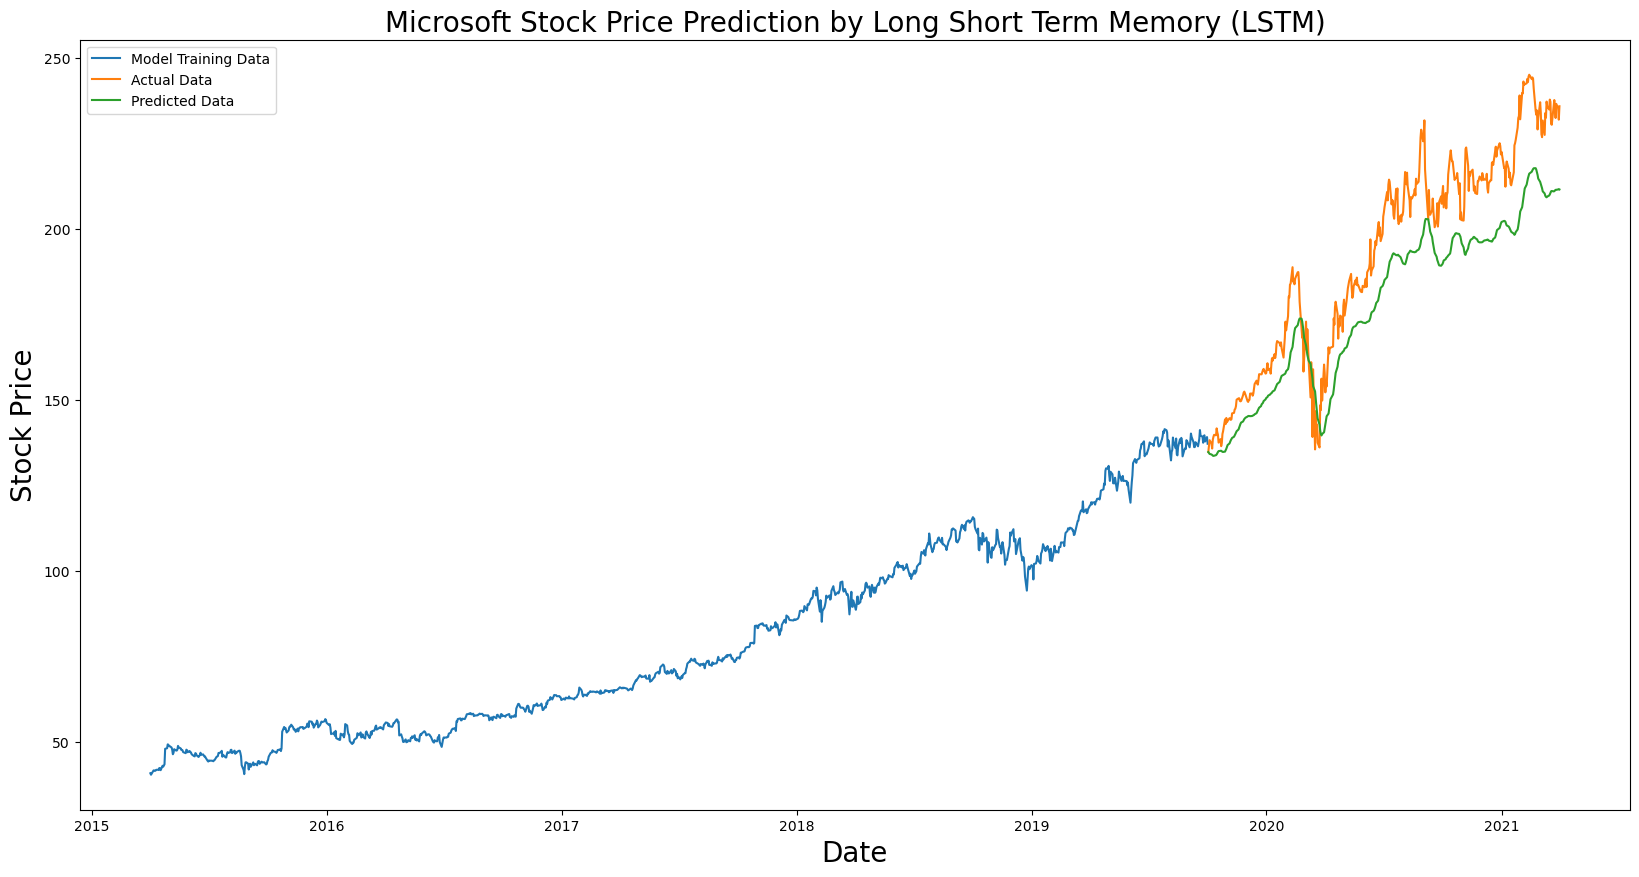

In [119]:
# Plot the training data, actual validation data, and predicted data
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.xlabel('Date', size=20)
plt.ylabel('Stock Price', size=20)
plt.title('Microsoft Stock Price Prediction by Long Short Term Memory (LSTM)', size=20)
plt.legend(['Model Training Data', 'Actual Data', 'Predicted Data'])
plt.show()

# Linear Regression Model

## Prepairing Data

In [120]:
# Get the number of rows in the dataset
Shape = df.shape[0]

# Extracting the 'Close' column for analysis
df_new = df[['Close']]
df_new.head()

# Split the data into training and validation sets (75% - 25% split)
train_data_set = df_new.iloc[:ceil(Shape * 0.75)]
valid_data_set = df_new.iloc[ceil(Shape * 0.75):]

print("**********STOCK PRICE PREDICTION BY LINEAR REGRESSION******")
print('Shape of Training dataset Set:', train_data_set.shape)
print('Shape of Validation dataset Set:', valid_data_set.shape)

**********STOCK PRICE PREDICTION BY LINEAR REGRESSION******
Shape of Training dataset Set: (1134, 1)
Shape of Validation dataset Set: (377, 1)


##  Training and Validation Data

In [121]:
# Reset the index for train and validation data
train = train_data_set.reset_index()
valid = valid_data_set.reset_index()

# Convert dates to ordinal format for regression analysis
x_train = train['Date'].map(dt.datetime.toordinal)
y_train = train[['Close']]
x_valid = valid['Date'].map(dt.datetime.toordinal)
y_valid = valid[['Close']]


## Implementing Model

In [122]:
# Implement linear regression
Model = LinearRegression()

# Train the model on the training data
Model.fit(np.array(x_train).reshape(-1, 1), y_train)

# Predict the stock prices on the validation data
preds = Model.predict(np.array(x_valid).reshape(-1, 1))


## Calculatiing RMSE & Plotting Results

(Root Mean Square Error) RMSE value on validation set: 58.36609230803065


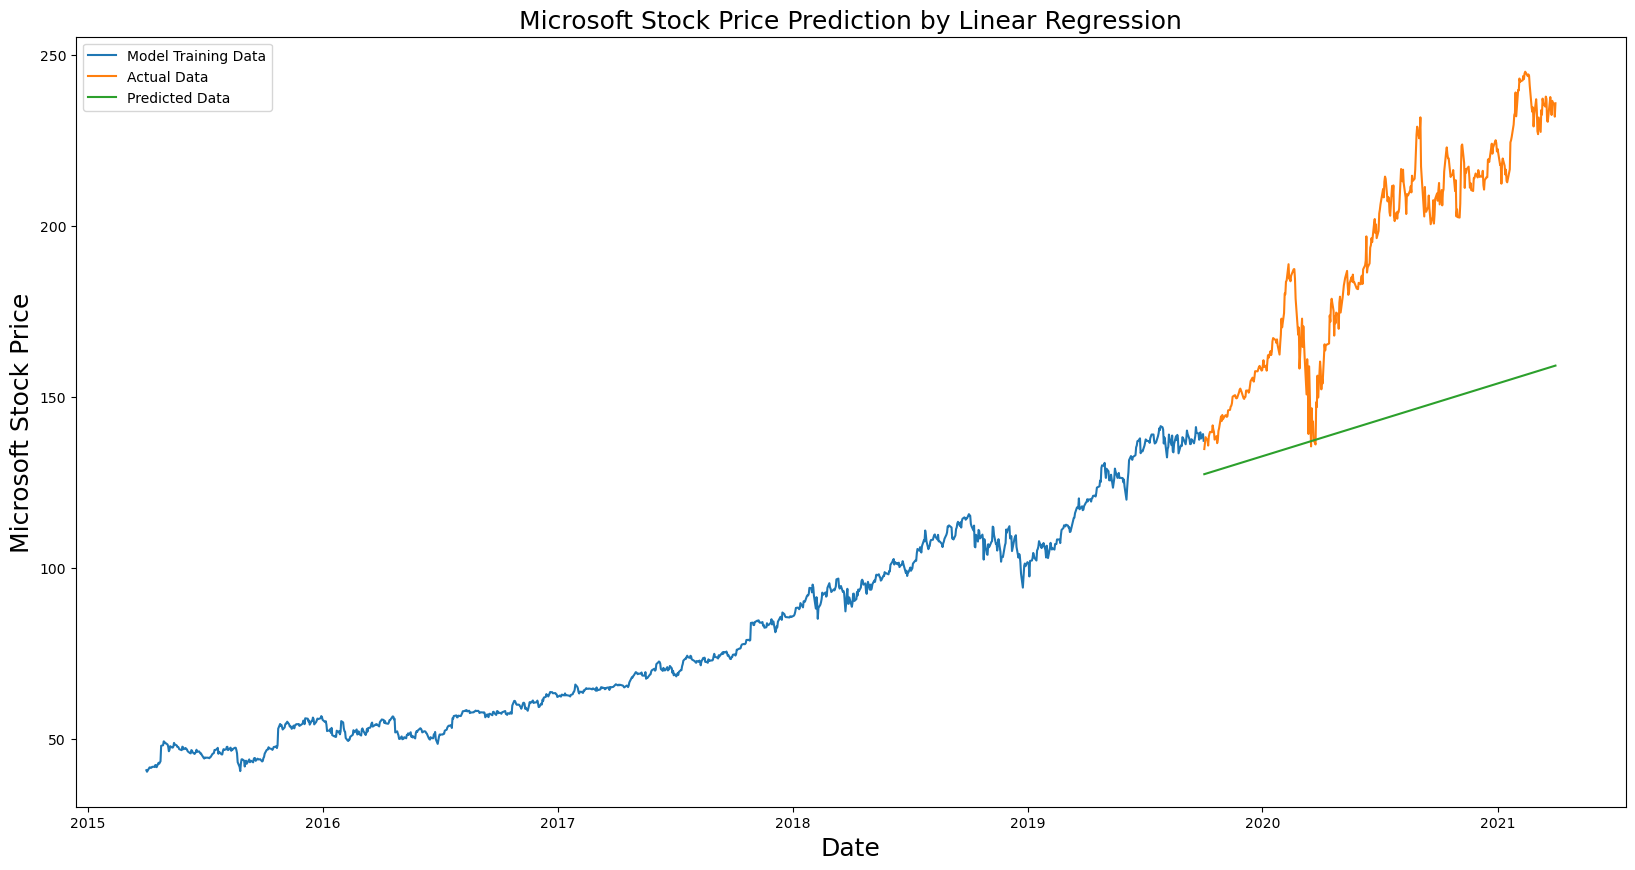

In [123]:
# Calculate the RMSE value
RMS = np.sqrt(np.mean(np.power((np.array(valid_data_set['Close']) - preds), 2)))
print('(Root Mean Square Error) RMSE value on validation set:', RMS)

# Add the predictions to the validation data
valid_data_set['Predictions'] = preds

# Plot the training data, actual validation data, and predicted data
plt.plot(train_data_set['Close'])
plt.plot(valid_data_set[['Close', 'Predictions']])
plt.xlabel('Date', size=18)
plt.ylabel('Microsoft Stock Price', size=18)
plt.title('Microsoft Stock Price Prediction by Linear Regression', size=18)
plt.legend(['Model Training Data', 'Actual Data', 'Predicted Data'])
plt.show()
